#GPU test

In [ ]:
#!nvidia-smi

#Install library

In [ ]:
!pip install contractions

#Warning disable

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Load data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/Shareddrives/PP NGHIÊN CỨU LIÊN NGÀNH/1. Cuối kỳ/Data/tripadvisor_hotel_reviews.csv')
df.rename(columns = {'Review':'review', 'Rating':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     20491 non-null  object
 1   sentiment  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df.head()

,review,sentiment
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


#Exploratory data analysis

In [ ]:
df = df.replace({'sentiment' : {1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5: 'positive' }})
df = df[df.sentiment != "neutral"]
df.head()

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive
5,love monaco staff husband stayed hotel crazy w...,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18307 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     18307 non-null  object
 1   sentiment  18307 non-null  object
dtypes: object(2)
memory usage: 429.1+ KB


Sentiment distribution

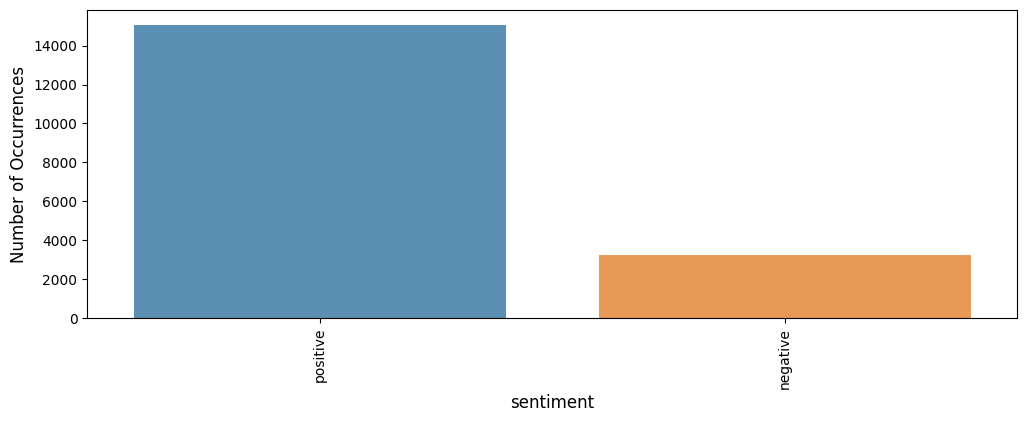

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

#Data preparation

Data cleaning

In [ ]:
from bs4 import BeautifulSoup

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [ ]:
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)

  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%%time
df.review = pre_process_corpus(df.review)

100%|██████████| 18307/18307 [00:15<00:00, 1212.41it/s]


CPU times: user 14.6 s, sys: 367 ms, total: 15 s
Wall time: 15.2 s


In [ ]:
df.head()

,review,sentiment
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
3,unique great stay wonderful time hotel monaco ...,positive
4,great stay great stay went seahawk game awesom...,positive
5,love monaco staff husband stayed hotel crazy w...,positive


Handling imbalance (oversampling)

In [ ]:
from sklearn.utils import resample
# Separate majority and minority classes in training data for upsampling
data_majority = df[df['sentiment'] == "positive"]
data_minority = df[df['sentiment'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
print("After upsampling\n",df_balance.sentiment.value_counts(),sep = "")

majority class before upsample: (15093, 2)
minority class before upsample: (3214, 2)
After upsampling
positive    15093
negative    15093
Name: sentiment, dtype: int64


Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((16476,), (1831,), (16476,), (1831,))

Tokenizer

In [ ]:
import keras
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_test)
t.word_index['<PAD>'] = 0

Sequence

In [ ]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [ ]:
VOCAB_SIZE = len(t.word_index)

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=18529
Number of Documents=1831


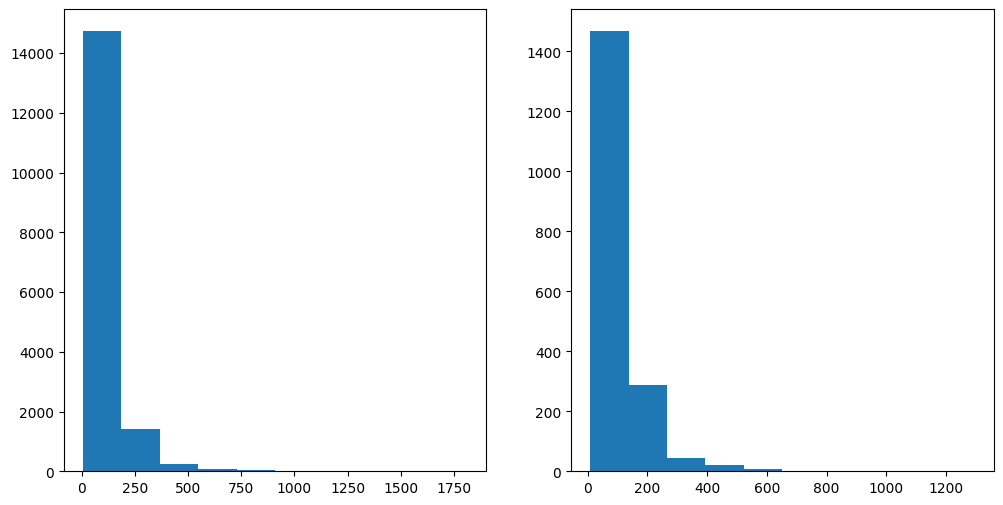

In [ ]:
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

Sequence Normalization

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100

# pad dataset to a maximum review length in words
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((16476, 100), (1831, 100))

Encoding Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#Modelling

Attention Mechanism

In [ ]:
from keras.layers import Layer
from keras import backend as K


class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None


    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W)
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Model Architecture

In [ ]:
import keras
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Concatenate, Dense, Dropout, LSTM
from keras.models import Model

EMBEDDING_DIM = 300
GRU_DIM = 32

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(sequence_input)
bigru = Bidirectional(GRU(GRU_DIM, return_sequences=True))(embedded_sequences)
att = AttentionLayer(MAX_SEQUENCE_LENGTH)(bigru)
dense1 = Dense(GRU_DIM*2, activation='relu')(att)
dropout1 = Dropout(rate=0.3)(dense1)
dense2 = Dense(GRU_DIM, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.3)(dense2)

outp = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=sequence_input, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 100, 300)          5558700   
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 64)           64128     
 onal)                                                           
                                                                 
 attention_layer_6 (Attenti  (None, 64)                164       
 onLayer)                                                        
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0   

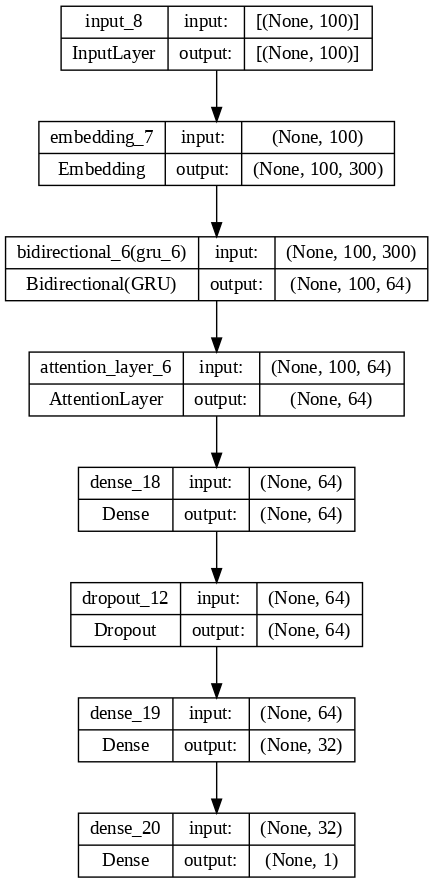

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi = 100)

Train model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('./best_model/best_model_gru.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8707
Epoch 1: val_accuracy improved from -inf to 0.93568, saving model to ./best_model/best_model_gru.h5
116/116 [==============================] - 43s 347ms/step - loss: 0.3319 - accuracy: 0.8707 - val_loss: 0.1591 - val_accuracy: 0.9357
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9635
Epoch 2: val_accuracy improved from 0.93568 to 0.94114, saving model to ./best_model/best_model_gru.h5
116/116 [==============================] - 25s 215ms/step - loss: 0.1060 - accuracy: 0.9635 - val_loss: 0.1645 - val_accuracy: 0.9411
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9822
Epoch 3: val_accuracy did not improve from 0.94114
116/116 [==============================] - 24s 205ms/step - loss: 0.0527 - accuracy: 0.9822 - val_loss: 0.2203 - val_accuracy: 0.9242
Epoch 4/100
116/116 [==============================] 

#Evaluation

Model Accuracy

In [ ]:
from keras.models import load_model

# Final evaluation of the model
# load the saved model
saved_model = load_model('./best_model/best_model_gru.h5', custom_objects={'AttentionLayer': AttentionLayer})
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

58/58 [==============================] - 1s 18ms/step - loss: 0.1736 - accuracy: 0.9312
Train: 98.26%, Test: 93.12%


Identify Overfitting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


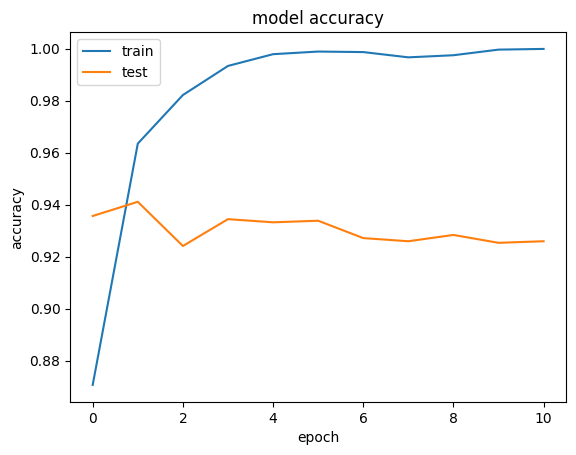

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model akurasi dropout 0.5 balance.jpg')
plt.show()

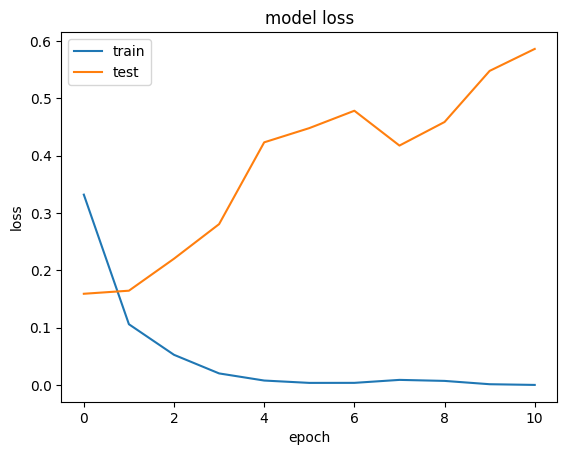

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model loss dropout 0.5 balance.jpg')
plt.show()

In [ ]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
#predictions = ['positive' if item == 1 else 'negative' for item in predictions]

58/58 [==============================] - 1s 17ms/step


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['positive', 'negative']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       341
           1       0.94      0.97      0.95      1490

    accuracy                           0.92      1831
   macro avg       0.88      0.84      0.86      1831
weighted avg       0.92      0.92      0.92      1831



,positive,negative
positive,243,98
negative,49,1441


ROC AUC

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.9468293018953335


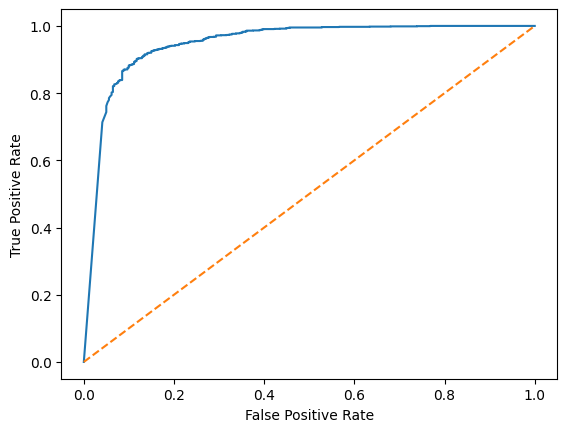

In [ ]:
plot_roc_curve(y_test, prediction_probs)
print(f'model AUC score: {roc_auc_score(y_test, prediction_probs)}')

Precision-Recall

model f1 score: 0.9514691317266425 model AUC score: 0.9861485262262778


Text(0, 0.5, 'Precision')

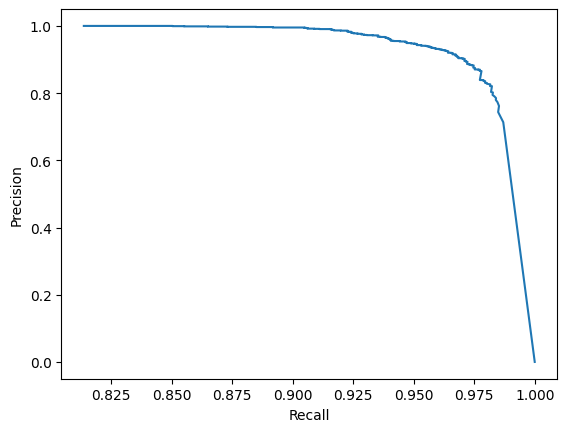

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, thresholds = precision_recall_curve(y_test, prediction_probs)
print(f'model f1 score: {f1_score(y_test, predictions)} model AUC score: {auc(recall, precision)}')
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')